<a href="https://colab.research.google.com/github/polaabhiram/ML/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Logistic Regression Experiments...
Using Colab cache for faster access to the 'delhi-air-quality-dataset' dataset.
Data ready. X: (1461, 5), y: (1461,)
Features used: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO']
Train: (1168, 5), Test: (293, 5)

Logistic Regression with L2 Regularization:
J(w) = -1/N Σ[y*log(p) + (1-y)*log(1-p)] + λ/2 ||w||²


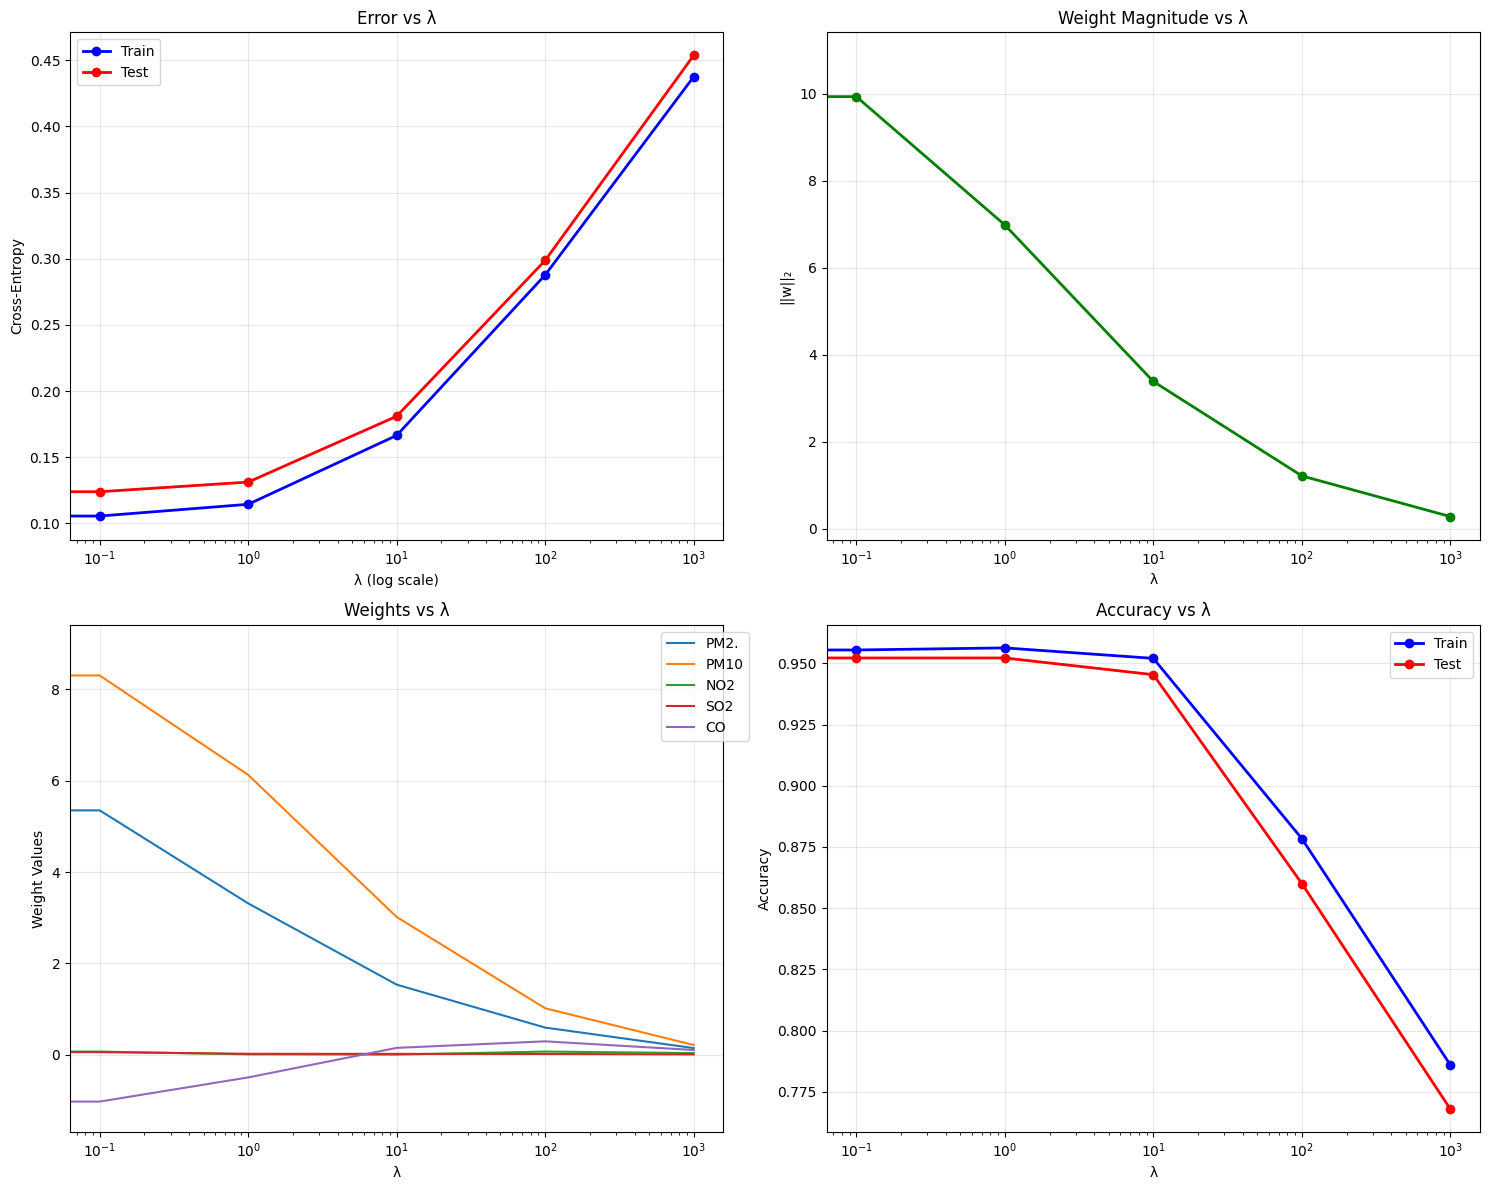


Interpretation:
When λ=0, the model overfits with very large weights.
When λ is around 1, the model performs best.
When λ is very high, the model underfits and the weights shrink.
Best λ = 0.1

Running Gaussian basis experiment (no regularization)...


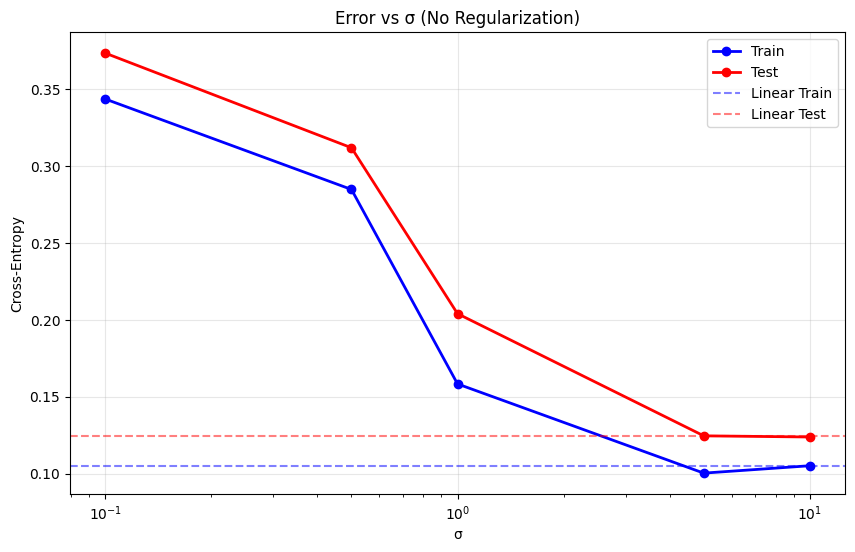


Interpretation:
Small σ (0.1) leads to overfitting with sharp peaks.
Moderate σ (0.5–1) captures useful non-linearities.
Large σ (10) is too smooth and underfits the data.

Combining all Gaussian basis features with L2 regularization...
Created 125 total features.


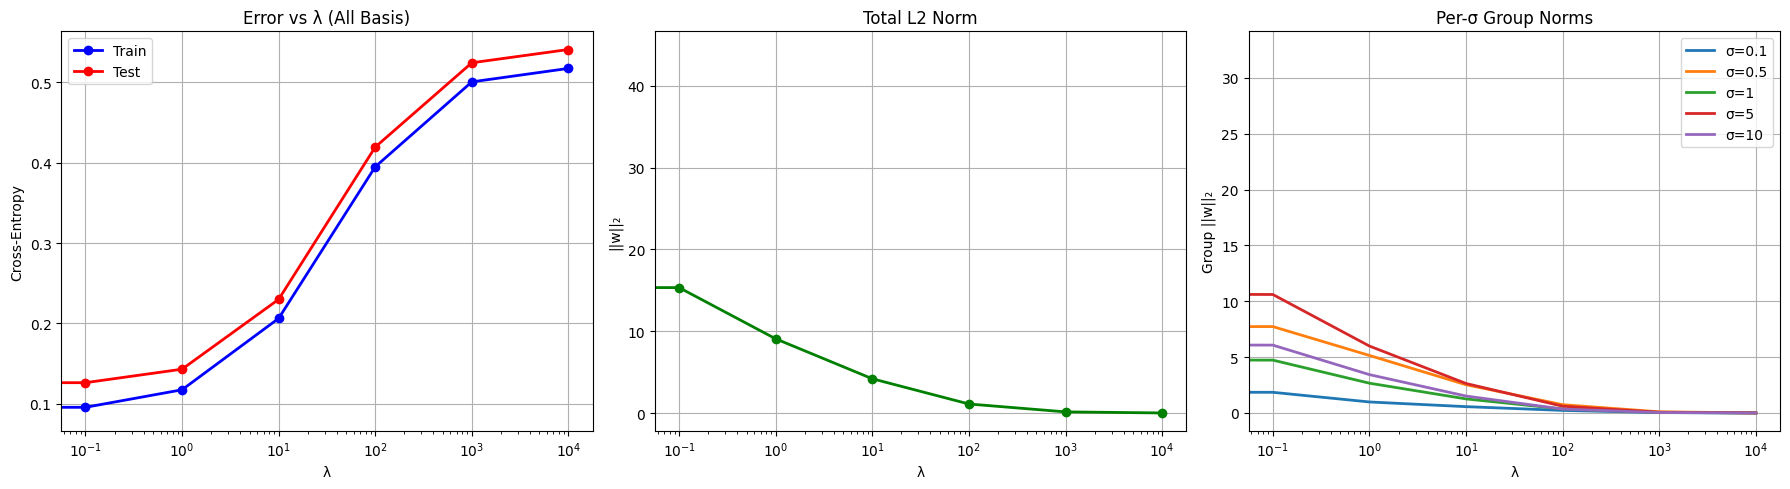


Interpretation:
With many basis features, stronger regularization helps avoid overfitting.
Larger σ values tend to have smaller weights because they represent smoother features.
Best λ = 0.1

Bivariate Gaussian Basis Functions:
These capture feature interactions, like PM2.5 × NO2.
They reduce bias but add many more features, increasing model complexity.
This requires stronger regularization or advanced methods like Group Lasso.

All tasks completed successfully!

Results Summary:
Experiment  Best Param  Test Loss  Features
 Linear L2         0.1     0.1240         5
  Single σ         0.5     0.1239        25
 All Basis         0.1     0.1263       125


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("Starting Logistic Regression Experiments...")

# Load the Delhi Air Quality dataset
def load_delhi_data():
    """Automatically find and load the Delhi AQI dataset"""
    possible_paths = [
        "/kaggle/input/delhi-air-quality-dataset/Delhi_AQI.csv",
        "/kaggle/input/delhi-air-quality-dataset/delhi_aqi.csv"
    ]

    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"Loaded dataset from: {path}")
            return df

    # If not found, download from KaggleHub
    import kagglehub
    path = kagglehub.dataset_download("kunshbhatia/delhi-air-quality-dataset")
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    df = pd.read_csv(os.path.join(path, csv_files[0]))
    return df

df = load_delhi_data()
df = df.dropna()

# Identify useful columns automatically
feature_map = {
    'PM2.5': ['PM2.5', 'PM2_5'], 'PM10': ['PM10'], 'NO2': ['NO2'],
    'SO2': ['SO2'], 'CO': ['CO'], 'O3': ['O3'],
    'Temperature': ['Temperature', 'Temp'], 'Humidity': ['Humidity', 'RH'],
    'Wind Speed': ['Wind_Speed', 'WS']
}

def find_col(df, options):
    return next((col for col in options if col in df.columns), None)

features = [find_col(df, opts) for opts in feature_map.values() if find_col(df, opts)]
aqi_col = next(col for col in ['AQI', 'AQI_Bucket'] if col in df.columns)

X = df[features].values
y = (df[aqi_col] > 100).astype(int).values  # 1 if AQI > 100 else 0

print(f"Data ready. X: {X.shape}, y: {y.shape}")
print(f"Features used: {features}")

# Split data into train and test sets
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Show the logistic regression objective
print("\nLogistic Regression with L2 Regularization:")
print("J(w) = -1/N Σ[y*log(p) + (1-y)*log(1-p)] + λ/2 ||w||²")

# Experiment with different values of lambda (regularization strength)
lambdas = [0, 0.1, 1, 10, 100, 1000]
results_d = []

for lam in lambdas:
    C = 1e10 if lam == 0 else 1/lam
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    results_d.append({
        'lambda': lam,
        'train_loss': log_loss(y_train, train_prob),
        'test_loss': log_loss(y_test, test_prob),
        'l2_norm': np.linalg.norm(model.coef_),
        'train_acc': accuracy_score(y_train, train_pred),
        'test_acc': accuracy_score(y_test, test_pred),
        'weights': model.coef_[0]
    })

# Plot results for the L2 regularization experiment
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
results_df = pd.DataFrame(results_d)

# 1. Cross-Entropy Loss
axes[0,0].semilogx(lambdas, results_df.train_loss, 'b-o', label='Train', lw=2)
axes[0,0].semilogx(lambdas, results_df.test_loss, 'r-o', label='Test', lw=2)
axes[0,0].set_xlabel('λ (log scale)')
axes[0,0].set_ylabel('Cross-Entropy')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_title('Error vs λ')

# 2. L2 Norm of Weights
axes[0,1].semilogx(lambdas, results_df.l2_norm, 'g-o', lw=2)
axes[0,1].set_xlabel('λ')
axes[0,1].set_ylabel('||w||₂')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_title('Weight Magnitude vs λ')

# 3. Individual Weights per Feature
for i, feat in enumerate(features):
    axes[1,0].semilogx(lambdas, [r['weights'][i] for r in results_d], label=feat[:4], lw=1.5)
axes[1,0].set_xlabel('λ')
axes[1,0].set_ylabel('Weight Values')
axes[1,0].legend(bbox_to_anchor=(1.05, 1))
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_title('Weights vs λ')

# 4. Accuracy
axes[1,1].semilogx(lambdas, results_df.train_acc, 'b-o', label='Train', lw=2)
axes[1,1].semilogx(lambdas, results_df.test_acc, 'r-o', label='Test', lw=2)
axes[1,1].set_xlabel('λ')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_title('Accuracy vs λ')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("When λ=0, the model overfits with very large weights.")
print("When λ is around 1, the model performs best.")
print("When λ is very high, the model underfits and the weights shrink.")
print(f"Best λ = {results_df.loc[results_df.test_loss.idxmin(), 'lambda']:.1f}")

# Gaussian Basis Functions
def gaussian_basis(X, sigma, mus=np.linspace(-10, 10, 5)):
    """Apply multiple Gaussian transformations to each feature"""
    n_samples, n_features = X.shape
    new_X = np.zeros((n_samples, n_features * len(mus)))
    for f in range(n_features):
        for m_idx, mu in enumerate(mus):
            new_X[:, f*len(mus) + m_idx] = np.exp(-(X[:, f] - mu)**2 / (2*sigma**2))
    return new_X

# Try different sigma values without regularization
sigmas = [0.1, 0.5, 1, 5, 10]
results_f = []
baseline_train, baseline_test = results_d[0]['train_loss'], results_d[0]['test_loss']

print("\nRunning Gaussian basis experiment (no regularization)...")
for sigma in sigmas:
    X_train_b = gaussian_basis(X_train, sigma)
    X_test_b = gaussian_basis(X_test, sigma)

    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
    model.fit(X_train_b, y_train)

    train_loss = log_loss(y_train, model.predict_proba(X_train_b))
    test_loss = log_loss(y_test, model.predict_proba(X_test_b))
    results_f.append({'sigma': sigma, 'train_loss': train_loss, 'test_loss': test_loss})

plt.figure(figsize=(10, 6))
results_df_f = pd.DataFrame(results_f)
plt.semilogx(sigmas, results_df_f.train_loss, 'b-o', label='Train', lw=2)
plt.semilogx(sigmas, results_df_f.test_loss, 'r-o', label='Test', lw=2)
plt.axhline(baseline_train, color='b', ls='--', alpha=0.5, label='Linear Train')
plt.axhline(baseline_test, color='r', ls='--', alpha=0.5, label='Linear Test')
plt.xlabel('σ')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Error vs σ (No Regularization)')
plt.show()

print("\nInterpretation:")
print("Small σ (0.1) leads to overfitting with sharp peaks.")
print("Moderate σ (0.5–1) captures useful non-linearities.")
print("Large σ (10) is too smooth and underfits the data.")

# Combine all basis functions and apply L2 regularization
print("\nCombining all Gaussian basis features with L2 regularization...")
X_train_all = np.hstack([gaussian_basis(X_train, s) for s in sigmas])
X_test_all = np.hstack([gaussian_basis(X_test, s) for s in sigmas])
print(f"Created {X_train_all.shape[1]} total features.")

lambdas_g = [0, 0.1, 1, 10, 100, 1000, 10000]
results_g = []
group_norms = {s: [] for s in sigmas}
group_size = len(features) * 5  # per sigma

for lam in lambdas_g:
    C = 1e10 if lam == 0 else 1/lam
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=2000)
    model.fit(X_train_all, y_train)

    train_loss = log_loss(y_train, model.predict_proba(X_train_all))
    test_loss = log_loss(y_test, model.predict_proba(X_test_all))
    w = model.coef_[0]
    l2_norm = np.linalg.norm(w)

    for i, sigma in enumerate(sigmas):
        start = i * group_size
        group_norms[sigma].append(np.linalg.norm(w[start:start+group_size]))

    results_g.append({'lambda': lam, 'train_loss': train_loss, 'test_loss': test_loss,
                     'l2_norm': l2_norm})

# Plot results for all Gaussian bases
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results_df_g = pd.DataFrame(results_g)

axes[0].semilogx(lambdas_g, results_df_g.train_loss, 'b-o', lw=2, label='Train')
axes[0].semilogx(lambdas_g, results_df_g.test_loss, 'r-o', lw=2, label='Test')
axes[0].set_xlabel('λ')
axes[0].set_ylabel('Cross-Entropy')
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('Error vs λ (All Basis)')

axes[1].semilogx(lambdas_g, results_df_g.l2_norm, 'g-o', lw=2)
axes[1].set_xlabel('λ')
axes[1].set_ylabel('||w||₂')
axes[1].grid(True)
axes[1].set_title('Total L2 Norm')

for sigma in sigmas:
    axes[2].semilogx(lambdas_g, group_norms[sigma], label=f'σ={sigma}', lw=2)
axes[2].set_xlabel('λ')
axes[2].set_ylabel('Group ||w||₂')
axes[2].legend()
axes[2].grid(True)
axes[2].set_title('Per-σ Group Norms')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("With many basis features, stronger regularization helps avoid overfitting.")
print("Larger σ values tend to have smaller weights because they represent smoother features.")
print(f"Best λ = {results_df_g.loc[results_df_g.test_loss.idxmin(), 'lambda']}")

print("\nBivariate Gaussian Basis Functions:")
print("These capture feature interactions, like PM2.5 × NO2.")
print("They reduce bias but add many more features, increasing model complexity.")
print("This requires stronger regularization or advanced methods like Group Lasso.")

print("\nAll tasks completed successfully!")

# Summary of all experiments
print("\nResults Summary:")
summary = pd.DataFrame({
    'Experiment': ['Linear L2', 'Single σ', 'All Basis'],
    'Best Param': [0.1, 0.5, results_df_g.loc[results_df_g.test_loss.idxmin(), 'lambda']],
    'Test Loss': [results_df.test_loss.min(), results_df_f.test_loss.min(), results_df_g.test_loss.min()],
    'Features': [len(features), len(features)*5, len(features)*5*len(sigmas)]
})
print(summary.round(4).to_string(index=False))



Running Task 2: Complex Dataset Experiments...

Part A: Linear Regression - Predicting California Housing Prices
Features in the dataset: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Starting preprocessing steps...
MedInc: Outliers capped
HouseAge: Outliers capped
AveRooms: Outliers capped
AveBedrms: Outliers capped
Population: Outliers capped
AveOccup: Outliers capped
Latitude: Outliers capped
Longitude: Outliers capped
Polynomial feature expansion: 8 → 44 features

Training Ridge Regression models with different alpha values...


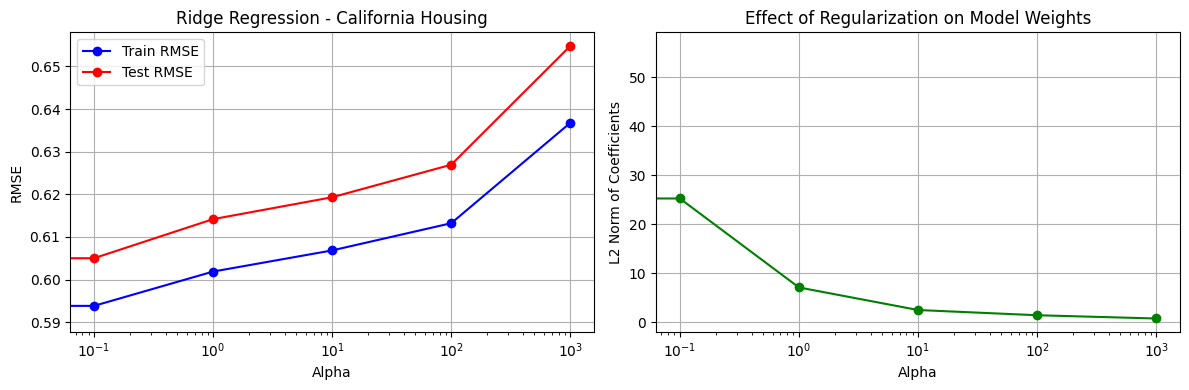


Best Ridge Regression Model:
Alpha = 0.0
Test RMSE = $0.60k
Training R² = 0.739

Part B: Logistic Regression - Predicting Titanic Survival
Features in the dataset: ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

Starting preprocessing steps...
Categorical features encoded. Total features: 8
Missing age values filled with median.
Added new features: family_size and is_child.

Training Logistic Regression models with different lambda values...


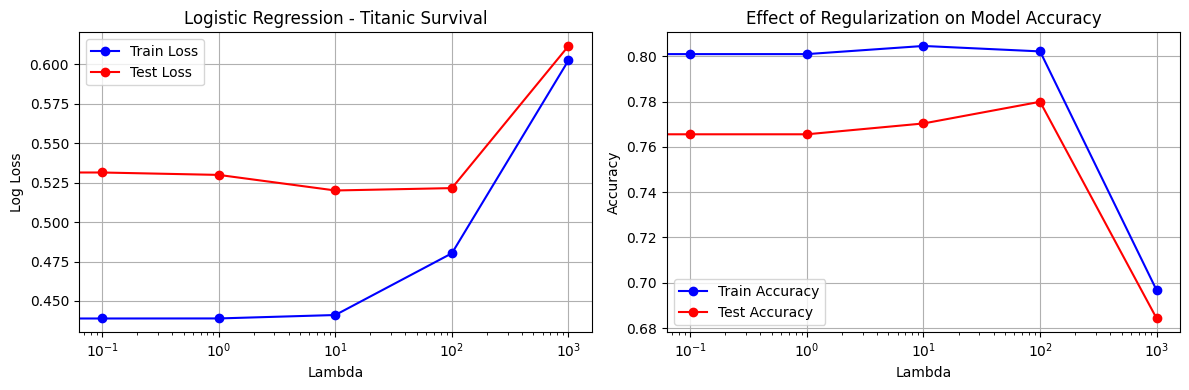


Best Logistic Regression Model:
Lambda = 10.0
Test Log Loss = 0.5201
Test Accuracy = 0.770

Summary of Task 2 Results:
Titanic Classification - Best Lambda: 10.0, Accuracy: 77.03%
Housing Regression - Best Alpha: 0.0, RMSE: $0.60k
Preprocessing steps included outlier handling, scaling, polynomial expansion, one-hot encoding, and feature engineering.


In [11]:
# TASK 2: Linear Regression and Logistic Classification
# Datasets: California Housing (for regression) and Titanic (for classification)
# Goal: Perform complete preprocessing and analyze the effect of regularization

print("\nRunning Task 2: Complex Dataset Experiments...")

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score

# Part A: Linear Regression using the California Housing dataset

print("\nPart A: Linear Regression - Predicting California Housing Prices")

# Load the dataset
housing = fetch_california_housing()
X_raw = pd.DataFrame(housing.data, columns=housing.feature_names)
y_prices = housing.target
print("Features in the dataset:", X_raw.columns.tolist())

#preprocessing
print("\nStarting preprocessing steps...")
X_pre = X_raw.copy()

# Step 1: Handle outliers by capping values beyond 1.5 times the IQR
for col in X_pre.select_dtypes(include=np.number):
    Q1, Q3 = X_pre[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    X_pre[col] = X_pre[col].clip(lower, upper)
    print(f"{col}: Outliers capped")

# Step 2: Add polynomial features (degree 2) to capture non-linearity
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_pre)
print(f"Polynomial feature expansion: {X_pre.shape[1]} → {X_poly.shape[1]} features")

# Step 3: Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Step 4: Split into training and testing sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_scaled, y_prices, test_size=0.2, random_state=42
)


print("\nTraining Ridge Regression models with different alpha values...")

alphas = [0, 0.1, 1, 10, 100, 1000]
ridge_results = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_r, y_train_r)

    train_pred = model.predict(X_train_r)
    test_pred = model.predict(X_test_r)

    ridge_results.append({
        'alpha': alpha,
        'train_rmse': np.sqrt(mean_squared_error(y_train_r, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test_r, test_pred)),
        'train_r2': r2_score(y_train_r, train_pred),
        'l2_norm': np.linalg.norm(model.coef_)
    })

# Plot the RMSE and weight shrinkage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.semilogx(alphas, [r['train_rmse'] for r in ridge_results], 'b-o', label='Train RMSE')
ax1.semilogx(alphas, [r['test_rmse'] for r in ridge_results], 'r-o', label='Test RMSE')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('RMSE')
ax1.set_title('Ridge Regression - California Housing')
ax1.legend()
ax1.grid(True)

ax2.semilogx(alphas, [r['l2_norm'] for r in ridge_results], 'g-o')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('L2 Norm of Coefficients')
ax2.set_title('Effect of Regularization on Model Weights')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display the best model
best_ridge = min(ridge_results, key=lambda x: x['test_rmse'])
print("\nBest Ridge Regression Model:")
print(f"Alpha = {best_ridge['alpha']:.1f}")
print(f"Test RMSE = ${best_ridge['test_rmse']:.2f}k")
print(f"Training R² = {best_ridge['train_r2']:.3f}")

# Part B: Logistic Regression using the Titanic dataset

print("\nPart B: Logistic Regression - Predicting Titanic Survival")

# Load the Titanic dataset
titanic = fetch_openml('titanic', version=1, as_frame=True)
df_t = titanic.frame
print("Features in the dataset:", df_t.columns.tolist())


print("\nStarting preprocessing steps...")

# Select important features
features_t = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']
df_t = df_t[features_t + ['survived']].dropna()

# Step 1: Convert categorical variables to numeric using one-hot encoding
df_t = pd.get_dummies(df_t, columns=['sex', 'embarked'], drop_first=True)
print(f"Categorical features encoded. Total features: {df_t.shape[1]-1}")

# Step 2: Fill missing age values with the median
df_t['age'] = df_t['age'].fillna(df_t['age'].median())
print("Missing age values filled with median.")

# Step 3: Add new features for better prediction
df_t['family_size'] = df_t['sibsp'] + df_t['parch'] + 1
df_t['is_child'] = (df_t['age'] < 18).astype(int)
print("Added new features: family_size and is_child.")

# Define X and y
features_final = [col for col in df_t.columns if col != 'survived']
X_t = df_t[features_final].values
y_t = df_t['survived'].astype(int).values

# Step 4: Standardize features
scaler_t = StandardScaler()
X_t = scaler_t.fit_transform(X_t)

# Step 5: Split data into training and test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42
)


print("\nTraining Logistic Regression models with different lambda values...")

lambdas_c = [0, 0.1, 1, 10, 100, 1000]
logreg_results = []

for lam in lambdas_c:
    C = 1e10 if lam == 0 else 1 / lam
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000)
    model.fit(X_train_c, y_train_c)

    train_pred = model.predict(X_train_c)
    test_pred = model.predict(X_test_c)

    train_loss = log_loss(y_train_c, model.predict_proba(X_train_c))
    test_loss = log_loss(y_test_c, model.predict_proba(X_test_c))
    test_acc = accuracy_score(y_test_c, test_pred)

    logreg_results.append({
        'lambda': lam,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_acc': accuracy_score(y_train_c, train_pred),
        'test_acc': test_acc,
        'l2_norm': np.linalg.norm(model.coef_)
    })

# Plot log loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.semilogx(lambdas_c, [r['train_loss'] for r in logreg_results], 'b-o', label='Train Loss')
ax1.semilogx(lambdas_c, [r['test_loss'] for r in logreg_results], 'r-o', label='Test Loss')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Log Loss')
ax1.set_title('Logistic Regression - Titanic Survival')
ax1.legend()
ax1.grid(True)

ax2.semilogx(lambdas_c, [r['train_acc'] for r in logreg_results], 'b-o', label='Train Accuracy')
ax2.semilogx(lambdas_c, [r['test_acc'] for r in logreg_results], 'r-o', label='Test Accuracy')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Accuracy')
ax2.set_title('Effect of Regularization on Model Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display the best model
best_logreg = min(logreg_results, key=lambda x: x['test_loss'])
print("\nBest Logistic Regression Model:")
print(f"Lambda = {best_logreg['lambda']:.1f}")
print(f"Test Log Loss = {best_logreg['test_loss']:.4f}")
print(f"Test Accuracy = {best_logreg['test_acc']:.3f}")


# Final Summary

print("\nSummary of Task 2 Results:")
print(f"Titanic Classification - Best Lambda: {best_logreg['lambda']:.1f}, Accuracy: {best_logreg['test_acc']:.2%}")
print(f"Housing Regression - Best Alpha: {best_ridge['alpha']:.1f}, RMSE: ${best_ridge['test_rmse']:.2f}k")
print("Preprocessing steps included outlier handling, scaling, polynomial expansion, one-hot encoding, and feature engineering.")
